## Bootstrapping, Random Forest e Cross-Validation

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Boostraping

A ideia desse exercício é visualizar uma amostragem com bootstraping. Para isso, vamos criar um conjunto de dados simples de 20 observações numeradas de 1 a 20.

In [7]:
dados = np.arange(1, 21) 
print(dados)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [ ]:
np.random.seed(42)
amostra_bootstrap = np.random.choice(dados, size=len(dados), replace=True)
print(amostra_bootstrap)

[ 7 20 15 11  8  7 19 11 11  4  8  3  2 12  6  2  1 12 12 17]
int64


In [11]:
out_of_bag = np.setdiff1d(dados, amostra_bootstrap)
print(out_of_bag)

[ 5  9 10 13 14 16 18]


Podemos ver que 7 dos 20 possíveis números não apareceram (7/20 = 35%), similar ao número levantado de que aproximadamente 1/3 das amostras ficam de fora do bootstrap. Repetindo esse processo várias vezes, para ter uma estimativa mais precisa:

In [12]:
proporcoes = []

for _ in range(1000):
    amostra = np.random.choice(range(100), size=100, replace=True)
    oob = len(set(range(100)) - set(amostra))
    proporcoes.append(oob / 100)
    
proporcao_oob = np.mean(proporcoes)
print(proporcao_oob)

0.36549


Repetindo o processo 1000 vezes, vemos uma proporção de aproximadamente 37% de amostras que ficam de fora. A ideia do que fizemos agora é justamente a ideia do bootstrap: ao combinar muitos itens fracos mas diferentes, o erro aleatório de cada um se cancela, e o resultado final é mais robusto. Visualizando algumas amostras Bootstrap:


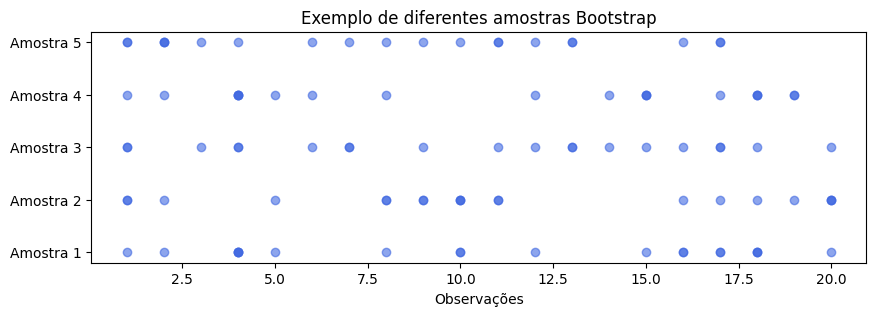

In [13]:
plt.figure(figsize=(10, 3))
for i in range(5):
    amostra = np.random.choice(dados, size=len(dados), replace=True)
    plt.scatter(amostra, [i]*len(dados), color='royalblue', alpha=0.6)
plt.yticks(range(5), [f"Amostra {i+1}" for i in range(5)])
plt.title("Exemplo de diferentes amostras Bootstrap")
plt.xlabel("Observações")
plt.show()

### Random Forest

Agora, usaremos o dataset Iris para treinar um modelo RandomForest, que combina muitas árvores de decisão treinadas em amostras Bootstrap diferentes.

In [30]:
iris = load_iris()

In [46]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

In [48]:
print(X.columns)
print(y.nunique())

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')
3


Ele tem 4 variáveis preditoras e 3 classes.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
rf = RandomForestClassifier(
    n_estimators=10,      # número de árvores
    random_state=42,
    oob_score=True,       # ativa cálculo de erro OOB
    bootstrap=True        # usa amostras bootstrap
)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


Acurácia Out-Of-Bag:

In [51]:
print(rf.oob_score_)

0.9416666666666667


In [52]:
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [53]:
print(acc)

0.9666666666666667


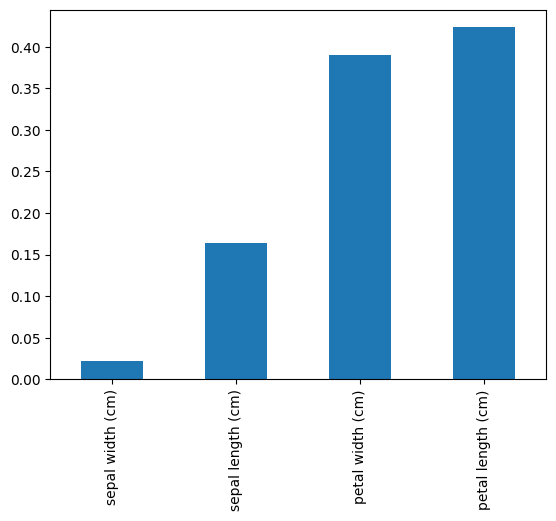

In [54]:
importancias = pd.Series(rf.feature_importances_, index=iris.feature_names)
importancias.sort_values().plot(kind='bar')
plt.show()

### Cross-Validation

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [56]:
scores = cross_val_score(rf, X, y, cv=kf)

In [57]:
print(scores)
print(scores.mean())

[1.         0.96666667 0.93333333 0.93333333 0.93333333]
0.9533333333333335


In [58]:
fold = 1
scores = []
for train_index, test_index in kf.split(X):
    X_tr, X_val = X.iloc[train_index], X.iloc[test_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[test_index]
    model = RandomForestClassifier(n_estimators=20, random_state=42)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_val)
    score = accuracy_score(y_val, pred)
    print(f"Fold {fold}: Acurácia = {score:.2f}")
    scores.append(score)
    fold += 1

Fold 1: Acurácia = 1.00
Fold 2: Acurácia = 0.97
Fold 3: Acurácia = 0.93
Fold 4: Acurácia = 0.90
Fold 5: Acurácia = 0.97


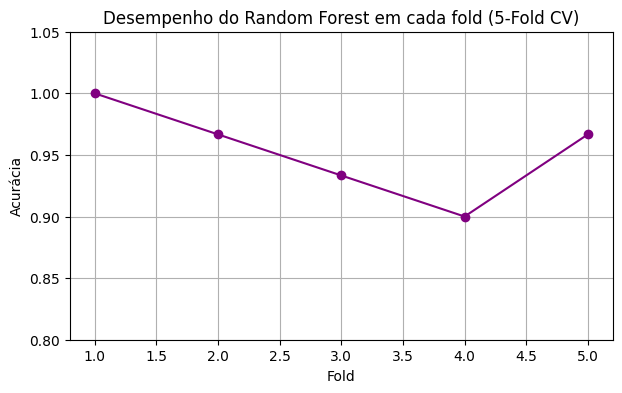

In [59]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 6), scores, marker='o', color='purple')
plt.title("Desempenho do Random Forest em cada fold (5-Fold CV)")
plt.xlabel("Fold")
plt.ylabel("Acurácia")
plt.ylim(0.8, 1.05)
plt.grid(True)
plt.show()


Como a acurácia varia pouco entre os folds, podemos concluir que o modelo é estável e generaliza bem.